In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

import numpy as np
import pandas as pd

import dill
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import gc
from tqdm import tqdm
import time
import nltk
import random
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_log_error, mean_squared_error

SEED=42
def set_seed(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)

set_seed(SEED)

OOF_DIR = '/content/drive/MyDrive/citation_prediction/oof_nan/'
SUB_DIR = '/content/drive/MyDrive/citation_prediction/sub_nan/'
INPUT_DIR = '/content/drive/MyDrive/citation_prediction/input/'

データの読み込み

In [ ]:
train_df = pd.read_json(os.path.join(INPUT_DIR, 'train_data.json'), lines=True)
test_df = pd.read_json(os.path.join(INPUT_DIR, 'test_data.json'), lines=True)
train_exists_cites_df = train_df[train_df.cites.notnull()].reset_index(drop=True)
print(train_exists_cites_df.shape)

train_y = np.log1p(train_exists_cites_df.cites) - np.log1p(train_exists_cites_df.doi_cites)

(15117, 16)


In [ ]:
oof_one = pd.read_feather(os.path.join(OOF_DIR, 'oof_1.feather'))
oof_two = pd.read_feather(os.path.join(OOF_DIR, 'oof_2.feather'))
oof_three = pd.read_feather(os.path.join(OOF_DIR, 'oof_3.feather'))
oof_four = pd.read_feather(os.path.join(OOF_DIR, 'oof_4_v2.feather'))
oof_five = pd.read_feather(os.path.join(OOF_DIR, 'oof_5.feather'))
oof_six = pd.read_feather(os.path.join(OOF_DIR, 'oof_6.feather'))
oof_seven = pd.read_feather(os.path.join(OOF_DIR, 'oof_original.feather'))
oof_seven['oof'] = oof_seven['oof'] - np.log1p(train_exists_cites_df.doi_cites)

oof_seven

,id,oof
0,1403.7138,0.086976
1,1405.5857,-0.058582
2,1807.01034,0.244782
3,astro-ph/9908243,-0.848582
4,hep-ph/0103252,-0.265675
...,...,...
15112,1101.0194,1.172530
15113,astro-ph/9310031,-0.435477
15114,1206.1191,0.429382
15115,1903.02203,0.193296


In [ ]:
oof_one

,id,oof
0,1403.7138,0.120316
1,1405.5857,0.068640
2,1807.01034,0.298285
3,astro-ph/9908243,-1.004574
4,hep-ph/0103252,-0.252703
...,...,...
15112,1101.0194,0.976734
15113,astro-ph/9310031,-0.537599
15114,1206.1191,0.447509
15115,1903.02203,0.252982


In [ ]:
test_one = pd.read_csv(os.path.join(SUB_DIR, 'pred_lgbm_1.csv'))
test_two = pd.read_csv(os.path.join(SUB_DIR, 'pred_lgbm_2.csv'))
test_three = pd.read_csv(os.path.join(SUB_DIR, 'pred_lgbm_3.csv'))
test_four = pd.read_csv(os.path.join(SUB_DIR, 'pred_lgbm_4_v2.csv'))
test_five = pd.read_csv(os.path.join(SUB_DIR, 'pred_lgbm_5.csv'))
test_six = pd.read_csv(os.path.join(SUB_DIR, 'pred_lgbm_6.csv'))
test_seven = pd.read_csv(os.path.join(SUB_DIR, 'pred_lgbm_original.csv'))
test_seven['cites'] = test_seven['cites'] - np.log1p(test_df.doi_cites)

test_seven

,id,cites
0,1605.00995,0.826824
1,1206.6911,-0.203038
2,cond-mat/0504055,0.052171
3,astro-ph/9907297,-0.870640
4,1104.5407,-0.080472
...,...,...
59079,1210.4112,0.177868
59080,1701.03465,-0.009472
59081,1709.10428,0.529129
59082,gr-qc/9803020,-0.032332


In [ ]:
targets = ['cites']
for target in targets:
    
    blend_train = []
    blend_test = []

    # out of fold prediction
    blend_train.append(oof_one['oof'])
    blend_train.append(oof_two['oof'])
    blend_train.append(oof_three['oof'])
    blend_train.append(oof_four['oof'])
    blend_train.append(oof_five['oof'])
    blend_train.append(oof_six['oof'])
    blend_train.append(oof_seven['oof'])
    blend_train = np.array(blend_train)

    # submission scores
    blend_test.append(test_one[target])
    blend_test.append(test_two[target])
    blend_test.append(test_three[target])
    blend_test.append(test_four[target])
    blend_test.append(test_five[target])
    blend_test.append(test_six[target])
    blend_test.append(test_seven[target])
    blend_test = np.array(blend_test)
    
    def rmse_min_func(weights):
        final_prediction = 0
        for weight, prediction in zip(weights, blend_train):
            final_prediction += weight * prediction
        return np.sqrt(mean_squared_error(train_y, final_prediction))

    print('\n Finding Blending Weights ...')
    res_list = []
    weights_list = []

    for k in range(100):
        starting_values = np.random.uniform(size=len(blend_train))
        bounds = [(0, 1)]*len(blend_train)

        res = minimize(rmse_min_func,
                       starting_values,
                       method='L-BFGS-B',
                       bounds=bounds,
                       options={'disp': False,
                                'maxiter': 100000})

        res_list.append(res['fun'])
        weights_list.append(res['x'])

        print('{iter}\tScore: {score}\tWeights: {weights}'.format(
            iter=(k + 1),
            score=res['fun'],
            weights='\t'.join([str(item) for item in res['x']])))


    bestSC   = np.min(res_list)
    bestWght = weights_list[np.argmin(res_list)]
    weights  = bestWght
    blend_score = round(bestSC, 6)
    
    print('\n Ensemble Score: {best_score}'.format(best_score=bestSC))
    print('\n Best Weights: {weights}'.format(weights=bestWght))

    train_prices = np.zeros(len(blend_train[0]))
    test_prices  = np.zeros(len(blend_test[0]))

    print('\n Your final model:')
    for k in range(len(blend_test)):
        print(' %.6f * model-%d' % (weights[k], (k + 1)))
        test_prices += blend_test[k] * weights[k]

    for k in range(len(blend_train)):
        train_prices += blend_train[k] * weights[k]
        
    test_one[target] = (test_one[target].values*bestWght[0]   + 
                   test_two[target].values*bestWght[1]   + 
                   test_three[target].values*bestWght[2] + 
                   test_four[target].values*bestWght[3]  +
                   test_five[target].values*bestWght[4]  +
                   test_six[target].values*bestWght[5]  +
                   test_seven[target].values*bestWght[6])/sum(bestWght)


 Finding Blending Weights ...
1	Score: 0.47808654394350475	Weights: 0.0007550268082843813	0.3704693819229813	0.11030459299711425	0.24167101256077386	0.12343246031419966	0.11664688111315324	0.0631894838292923
2	Score: 0.478086493755078	Weights: 0.0	0.3728082331228314	0.10927850921909817	0.24096565837862022	0.12328802273000385	0.11711969592660149	0.06297952996626703
3	Score: 0.4780866263524153	Weights: 0.0017462925012691043	0.3758994893390683	0.10786425930548514	0.2394322548212721	0.12376965917294384	0.11630843741678906	0.061669821447238156
4	Score: 0.4780864975852235	Weights: 0.0	0.37271905756321955	0.10996467676262671	0.24059748467192357	0.12301860130485878	0.11714747186282577	0.06299127908209445
5	Score: 0.4780867256810245	Weights: 0.0	0.37772395428370936	0.11015726528144794	0.23490812816826329	0.12066776278007396	0.12014232425914609	0.06286967787232914
6	Score: 0.4780872586452449	Weights: 0.004158451933569646	0.38193029536086504	0.10556323991355304	0.2348832731464644	0.1209522331950

In [ ]:
# 0.47808649332547126

In [ ]:
test_one

,id,cites
0,1605.00995,0.792825
1,1206.6911,-0.087810
2,cond-mat/0504055,0.141031
3,astro-ph/9907297,-0.794532
4,1104.5407,-0.087423
...,...,...
59079,1210.4112,-0.003294
59080,1701.03465,0.005507
59081,1709.10428,0.459719
59082,gr-qc/9803020,-0.020135


In [ ]:
df_sub = pd.DataFrame()
df_sub["id"] = test_df["id"]
df_sub["cites"] = np.expm1(test_one['cites'].values + np.log1p(test_df.doi_cites))

df_sub.head()

,id,cites
0,1605.00995,12.257778
1,1206.6911,20.982435
2,cond-mat/0504055,107.237289
3,astro-ph/9907297,10.294819
4,1104.5407,10.911768


In [ ]:
df_sub.to_csv('/content/drive/MyDrive/citation_prediction/pred_lgbm_0327_6_category_to_nan_seed_42.csv', index=False)

In [ ]:
oof_one['oof'] = (oof_one['oof'].values*bestWght[0]   + 
                   oof_two['oof'].values*bestWght[1]   + 
                   oof_three['oof'].values*bestWght[2] + 
                   oof_four['oof'].values*bestWght[3]  +
                   oof_five['oof'].values*bestWght[4]  +
                   oof_six['oof'].values*bestWght[5]  +
                   oof_seven['oof'].values*bestWght[6])/sum(bestWght)

In [ ]:
oof_one

,id,oof
0,1403.7138,0.112673
1,1405.5857,0.086892
2,1807.01034,0.364718
3,astro-ph/9908243,-0.852179
4,hep-ph/0103252,-0.285065
...,...,...
15112,1101.0194,0.929781
15113,astro-ph/9310031,-0.530179
15114,1206.1191,0.468316
15115,1903.02203,0.283922


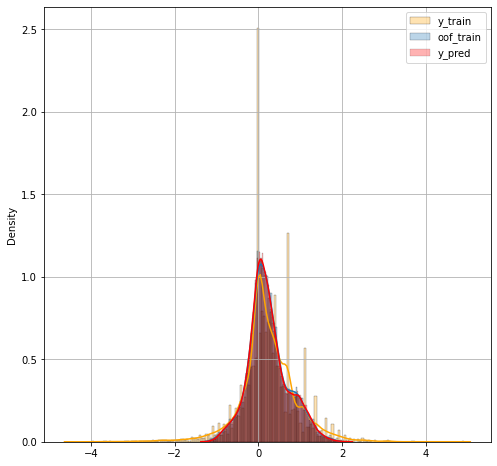

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(8, 8))
sns.histplot(train_y, label='y_train', kde=True ,stat="density", common_norm=False, color='orange', alpha=0.3)
sns.histplot(oof_one['oof'].values, label='oof_train', kde=True, stat="density", common_norm=False, alpha=0.3)
sns.histplot(test_one['cites'].values, label='y_pred', kde=True, stat="density", common_norm=False, color='red', alpha=0.3)
ax.legend()
ax.grid()